In [1]:
import sys
import os
import struct
import numpy as np
import datetime

import glob
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, EarthLocation,SkyCoord

In [2]:
CORR_HDR_MAGIC= 0x000000003B98F002 # Magic number in raw corr visibilities.
A06_HDR_MAGIC = 0x4141525446414143
A12_HDR_MAGIC = 0x4141525446414144
LEN_HDR       = 512

In [3]:
class TransitVis (object):
    fname       = None # Name of visibility binary file.
    hdr         = None # record header
    fvis        = None # File pointer to binary file
    nrec        = None # Total number of records in this file
    nbline      = None # Total number of baselines in this file
    tfilestart  = None # First timestamp in the file
    tfileend    = None # Last timestamp in the file

    # Information extracted from an individual header
    magic       = None
    trec        = None # Current records start time
    sub         = None # Subband number
    nant        = None # Total number of dual-pol antennas in the array.
    npol        = None # Number of polarizations in the observation
    pol2rec     = None # Number of polarizations per record.
    nchan       = None # Number of channels in this file
    norigchan   = None # Number of original channels before preprocessing.
    dt          = None # Integration time per record

    # Per polarization information
    flagged_channels= None # Independent per pol.
    flagged_dipoles = None # Independent per pol.
    ateamflux   = None # Independent per pol.
    weights     = None
    nweight     = None

    # Frequency associated with channel or averaged set of channels.
    freq        = None 

    recbuf      = None # Complete, single record read from file
    vis         = None # Usable visibility array per record (both pols)
    tstamps     = None # List containing timestamps of all records in a file.

    deblev      = None # Debug level for messages.
    missrec     = None # Number of records thrown due to mismatched times.

    # Function abstraction for raw and calibrated visibilities
    read_rec    = None # Function object, initialised to the right read func.
    read_hdr    = None # Function object, initialised to the right read func.
    parse_hdr   = None # Function object, initialised to the right parse func.

    def __init__ (self, fname, nant=None, sub=None, nchan=None, npol=None, 
                    arrayconfig=None):
        """ Initialization of internal state corresponding to a visibility dump.
            Since the correlator raw visibility magic number doesn't distinguish
            between AARTFAAC-6 or AARTFAAC-12, and has no subband information, 
            this can be supplied to the init routine.
        """
        # Check if fname is a valid file, and open
        self.fname = fname
        self.fvis = open (self.fname, 'r')
        self.hdr = self.fvis.read (LEN_HDR)
        self.npol = 2;

#         import pdb; pdb.set_trace();
        self.magic,self.tfilestart,trec = struct.unpack ("<Qdd", self.hdr[0:24])

#         if (self.magic == A06_HDR_MAGIC):
        self.nant     = 288
#             self.read_rec = self.read_cal
        self.parse_hdr= self.parse_cal_hdr
        self.read_hdr = self.read_cal_hdr
        self.nchan    = 1 # See record description in parse_cal_hdr
        self.nweight  = (6*7)/2 # Per station weights
        self.pol2rec  = 1



        # New format, stores only upper triangle float ACM
        self.nbline  = self.nant*(self.nant+1)/2
        # 8 due to float complex.
        self.payload = self.nbline * self.nchan * self.pol2rec * 8
        self.recsize = self.payload + LEN_HDR
        fsize = os.path.getsize(fname)

        # NOTE: We need to read 2 recs for getting both polarizations from .cal
        if self.magic == A12_HDR_MAGIC or self.magic == A06_HDR_MAGIC:
            self.nrec = fsize/(self.recsize*2)
        else:
            self.nrec = fsize/(self.recsize) # each record has both pols in .vis
            # First record has a corrupted timestamp in a .vis file
            self.fvis.seek (self.recsize, 0) 
            self.hdr = self.fvis.read (LEN_HDR)
            self.magic,self.tfilestart,trec = struct.unpack ("<Qdd", 
                                                        self.hdr[0:24])

        self.fvis.seek (0)
        self.dt = datetime.timedelta (seconds=(trec - self.tfilestart))# seconds
        self.tfilestart = datetime.datetime.utcfromtimestamp(self.tfilestart)
        
        # Find the last timestamp in a file.
        self.fvis.seek (0)
        self.fvis.seek ((self.nrec-1) * self.recsize)
        self.hdr = self.fvis.read (LEN_HDR)
        self.magic, self.tfileend, trec, self.sub, self.nant, pol, \
            self.norigchan, _, _, _, _, self.freq = self.parse_hdr (self.hdr)

        self.fvis.seek (0)


    def parse_cal_hdr(self, hdr):
        """
        Parse aartfaac header for calibrated data, independent per pol.
        Two pols are packed one after another, but with independent headers.
        struct output_header_t
        {
          uint64_t magic;                   ///< magic to determine header
          double start_time;                ///< start time (unix)
          double end_time;                  ///< end time (unix)
          int32_t subband;                  ///< lofar subband
          int32_t num_dipoles;              ///< number of dipoles (288 or 576)
          int32_t polarization;             ///< XX=0, YY=1
          int32_t num_channels;             ///< number of channels (<= 64)
          float ateam_flux[5];              ///< Ateam fluxes(CasA, CygA, Tau, Vir, Sun)
          std::bitset<5> ateam;             ///< Ateam active
          std::bitset<64> flagged_channels; ///< bitset of flagged channels (8 byte)
          std::bitset<576> flagged_dipoles; ///< bitset of flagged dipoles (72 byte)
          uint32_t weights[78];             ///< stationweights n*(n+1)/2, n in {6, 12}
          uint8_t pad[48];                  ///< 512 byte block
        };
        Record layout: The incoming channels in the raw visibilities from the
            correlator can be averaged in various combinations. The resulting
            averaged product gets its own record with an independent header.
            The record size for all records is the same, and corresponding data
            products (all records with the same channel integration, e.g.) will
            go into a single file. Other channel groups being averaged will go 
            into separate files.  
        """
        try:
            magic, t0, t1, sub, nant, pol, norigchan = struct.unpack("<Qddiiii",
                                                     hdr[0:40])
            ateamflux = struct.unpack("<fffff", hdr[40:60])
            ateam, flag_chans = struct.unpack("<QQ", hdr[60:76])
            flag_dips = struct.unpack ("<72b", hdr[76:148])
            weights = struct.unpack (("<%di" % self.nweight), 
                                    hdr[148:148+self.nweight*4]) # int weights
        except struct.error:
            print '### struct unpack error!'
            raise

        assert (magic == A06_HDR_MAGIC or magic == A12_HDR_MAGIC)
        # TODO: Examine the flagged channels to determine the actual frequency 
        # of the averaged channels. Currently return subband center.
        freq = sub * 195312.5 # Hz,
        
        return (magic, datetime.datetime.utcfromtimestamp(t0), datetime.datetime.utcfromtimestamp(t1), 
                sub, nant, pol, norigchan, ateamflux, flag_chans, flag_dips, weights, freq)

    # Return just the header, with metainformation extracted.
    # Faster than doing an actual read of the record payload.
    def read_cal_hdr (self, rec):
        
        assert (self.fvis)
        if (rec != None):
            raise NotImplemented

        # First pol.
        hdr = self.fvis.read (LEN_HDR)
        m, self.trec, t1, s, d, p, c, ateamflux, flag_chan, flag_dip, weights, \
                 freq = self.parse_hdr (hdr)
        self.ateamflux[p] = ateamflux
        self.flagged_dipoles[p] = flag_dip
        self.flagged_channels[p] = flag_chan

        self.fvis.seek (self.payload, 1)

        # Second polarization
        hdr = self.fvis.read (LEN_HDR)
        self.magic, trec, _, sub, self.nant, pol, \
            self.norigchan, ateamflux, flag_chan, flag_dip, weights, \
                    freq = self.parse_hdr (hdr)

        self.fvis.seek (self.payload, 1)
        # Check if both records correspond to the same trec
        # We can choose to keep only the single pol, or reject this record.
        if  (trec != self.trec):
            self.recbuf = 0
            self.fvis.seek (-self.recsize, 1) 
            print '## Mismatched times: pol %d tim: %s, pol %d tim: %s' \
                    % (p,self.trec, pol, trec)
            self.missrec = self.missrec + 1
            return -1

        self.ateamflux[p] = ateamflux
        self.flagged_dipoles[p] = flag_dip
        self.flagged_channels[p] = flag_chan

        return 1

In [4]:

fname = "/mnt/nex1/data/vis_archive/201702250130/299-201702250130.cal"

vis = TransitVis (fname)

print "start:", vis.tfilestart 
print "end:", vis.tfileend
print "alt end:", Time(vis.tfilestart) + vis.nrec*u.s

d = datetime.datetime(2018, 02, 15, 14, 10, 12)
print "check:", d #d.year, d.month, d.day, d.hour, d.minute, d.second
print "Time covered by calibrated vis: ",(vis.tfilestart < d) and (vis.tfileend > d)
print "Time covered by calibrated vis: ",(vis.tfilestart < d) and (Time(vis.tfilestart) + vis.nrec*u.s > d)

start: 2017-02-25 01:30:10.068455
end: 2017-02-25 03:19:33.315354
alt end: 2017-02-25 05:07:32.068455
check: 2018-02-15 14:10:12
Time covered by calibrated vis:  False
Time covered by calibrated vis:  False


In [137]:
# TODO:

# get closest without going over foldername
# ls /mnt/nex*/data/vis_archive/* -d

# get closest without going over file in folder 
# # if not possible, time not covered 

# compare check time to start and end time
# # return true or false



In [5]:

vis_archive = np.array(glob.glob("/mnt/nex*/data/vis_archive/*/*.cal"))


In [6]:
obs_dates = pd.to_datetime([x[-16:-4] for x in vis_archive])

unique_obs, unique_obs_index = np.unique([x[-16:-4] for x in vis_archive],return_index=True)

In [90]:
obs_dates[unique_obs_index]

DatetimeIndex(['2016-08-31 15:10:00', '2016-09-05 16:47:00',
               '2016-09-07 03:40:00', '2016-11-12 06:32:00',
               '2016-11-12 14:35:00', '2016-11-13 12:35:00',
               '2016-11-13 20:00:00', '2016-11-14 05:01:00',
               '2016-11-14 09:02:00', '2016-11-14 10:03:00',
               ...
               '2018-04-28 04:10:00', '2018-04-28 07:45:00',
               '2018-04-29 01:01:00', '2018-04-29 03:00:00',
               '2018-04-29 09:00:00', '2018-04-29 15:01:00',
               '2018-04-30 12:08:00', '2018-04-30 15:10:00',
               '2018-05-01 01:00:00', '2018-05-01 08:10:00'],
              dtype='datetime64[ns]', length=646, freq=None)

In [7]:
fermi = pd.read_csv('/home/kuiack/RECOVERED_FILES/kuiack/fermi_GRB_cat.csv')
swift = pd.read_csv("/home/kuiack/swift_GRB_cat.csv")

In [8]:
fermi["trigger_time"] = pd.to_datetime(fermi["trigger_time"])
swift["trigger_time"] = pd.to_datetime(swift["trigger_time"], errors='coerce')

In [48]:
swift.to_csv("/home/kuiack/swift_GRB_cat.csv", index=None)

In [9]:
swift.keys()
    

Index([u'GRB', u'Time [UT]', u'ra', u'dec', u'BAT T90 [sec]', u'trigger_time'], dtype='object')

In [99]:
fermi["trigger_time"].iloc[-1]

Timestamp('2014-03-11 21:14:35.646000')

In [11]:
CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

 fermi GRB found in: /mnt/nex1/data/vis_archive/201804271004/317-201804271004.cal
	fermi time: 	2018-04-27 10:37:03.044000 	283.33 70.3 331.19143166 43.7664736372
		2018-04-27 10:04:25.199590
		2018-04-27 17:11:09.199590
 fermi GRB found in: /mnt/nex1/data/vis_archive/201804261245/318-201804261245.cal
	fermi time: 	2018-04-26 13:11:00.846000 	202.41 58.17 20.2988358183 65.1101806031
		2018-04-26 12:45:10.442911
		2018-04-26 20:03:05.442911
 fermi GRB found in: /mnt/nex1/data/vis_archive/201804230020/318-201804230020.cal
	fermi time: 	2018-04-23 00:47:03.657000 	208.68 9.84 208.87580711 46.3021125134
		2018-04-23 00:20:19.822249
		2018-04-23 02:28:07.822249
 fermi GRB found in: /mnt/nex1/data/vis_archive/201803110000/345-201803110000.cal
	fermi time: 	2018-03-11 01:45:53.301000 	53.95 -35.77 294.50675753 151.697399311
		2018-03-11 00:00:11.903217
		2018-03-11 11:53:14.903217
 fermi GRB found in: /mnt/nex0/data/vis_archive/201801130322/228-201801130322.cal
	fermi time: 	2018-01-13 10:02:

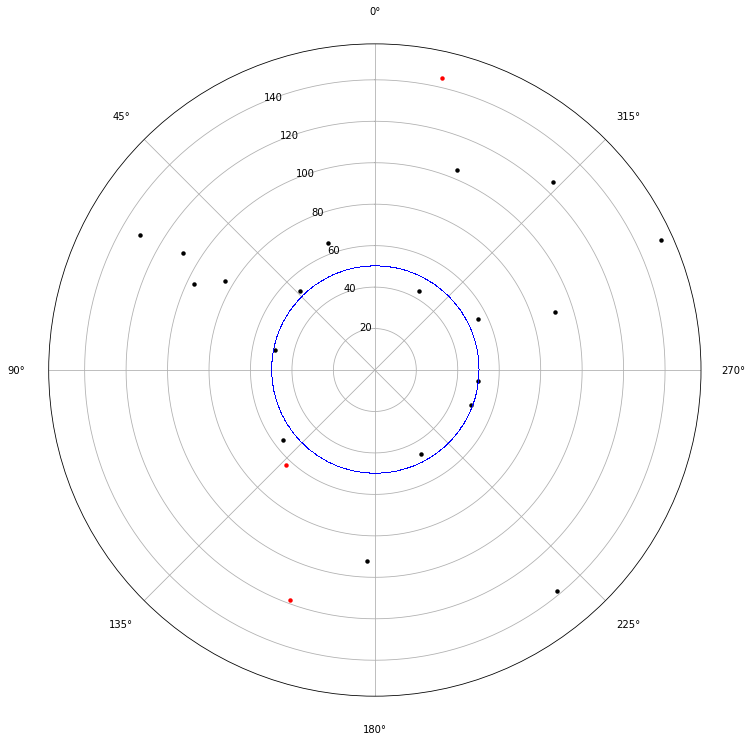

In [88]:
plt.figure(figsize=(12,12))
ax = plt.subplot(projection='polar')

for i in range(len(fermi["trigger_time"])):
#     print "fermi time:", fermi["trigger_time"].iloc[i]
    try:
        fermi_time = fermi["trigger_time"].iloc[i]
#     print obs_dates[unique_obs_index][obs_dates[unique_obs_index] < fermi["trigger_time"].iloc[i]][-1]
        vis = TransitVis (vis_archive[unique_obs_index][obs_dates[unique_obs_index] < fermi["trigger_time"].iloc[i]][-1])
    
        position = SkyCoord(fermi["ra"].iloc[i]*u.degree, fermi["dec"].iloc[i]*u.degree)
        altaz = position.transform_to(AltAz(obstime=fermi["trigger_time"].iloc[i], location=CS002))
    
        if fermi["trigger_time"].iloc[i] > vis.tfilestart and  fermi["trigger_time"].iloc[i] < vis.tfilestart + datetime.timedelta(seconds=vis.nrec):
            print " fermi GRB found in:",vis_archive[unique_obs_index][obs_dates[unique_obs_index] < fermi["trigger_time"].iloc[i]][-1]
            print '\t', "fermi time:",'\t', fermi["trigger_time"].iloc[i], '\t', fermi["ra"].iloc[i], fermi["dec"].iloc[i], altaz.az.deg, 90.-altaz.alt.deg
            print '\t','\t', vis.tfilestart
            print '\t','\t', vis.tfilestart + datetime.timedelta(seconds=vis.nrec)
            
            
            plt.scatter(altaz.az.rad,90-altaz.alt.deg,c="k", lw=0, s=20 )
            
# plt.plot(altaz.az.rad[:1000],np.abs(90-altaz.alt.deg)[:1000], ".", c=col_tup[:1000], lw=0 )

            
    except IndexError:
        continue 

for i in range(len(swift["trigger_time"])):
    try:
        swift_time = swift["trigger_time"].iloc[i]
        vis = TransitVis (vis_archive[unique_obs_index][obs_dates[unique_obs_index] < swift["trigger_time"].iloc[i]][-1])
    
        position = SkyCoord(swift["ra"].iloc[i]*u.degree, swift["dec"].iloc[i]*u.degree)
        altaz = position.transform_to(AltAz(obstime=swift["trigger_time"].iloc[i], location=CS002))
    
        if swift["trigger_time"].iloc[i] > vis.tfilestart and  swift["trigger_time"].iloc[i] < vis.tfilestart + datetime.timedelta(seconds=vis.nrec):
            print " swift GRB found in:",vis_archive[unique_obs_index][obs_dates[unique_obs_index] < swift["trigger_time"].iloc[i]][-1]
            print '\t', "swift time:",'\t', swift["trigger_time"].iloc[i], '\t', swift["ra"].iloc[i], swift["dec"].iloc[i], altaz.az.deg, 90.-altaz.alt.deg
            print '\t','\t', vis.tfilestart
            print '\t','\t', vis.tfilestart + datetime.timedelta(seconds=vis.nrec)
            
            
            plt.scatter(altaz.az.rad,90-altaz.alt.deg,c="r", lw=0, s=20 )
            
# plt.plot(altaz.az.rad[:1000],np.abs(90-altaz.alt.deg)[:1000], ".", c=col_tup[:1000], lw=0 )

            
    except IndexError:
        continue 
        
        
plt.plot(np.linspace(0,2*np.pi, 1000),50.*np.ones(1000),",",c="b")
ax.set_theta_zero_location("N")


In [13]:
len(fermi)

1000

In [27]:
position = SkyCoord(202.9*u.degree, 0.0*u.degree)
altaz = position.transform_to(AltAz(obstime="2018-04-23T00:47:01", location=CS002))
print altaz.az.deg, 90.-altaz.alt.deg

211.979034563 57.4321619406


In [70]:
delta = datetime.timedelta()


for obs in vis_archive[unique_obs_index]:
    vis = TransitVis (fname)

#     print "start:", vis.tfilestart 
#     print "alt end:", Time(vis.tfilestart) + vis.nrec*u.s
    
    delta += datetime.timedelta(seconds=vis.nrec)
    
    
print delta

97 days, 12:18:52


In [23]:


print vis.nrec
print Time(vis.tfilestart) + vis.nrec*u.s


13042
2017-02-25 05:07:32.068455


In [47]:


delta = dt.timedelta()

In [63]:
delta + dt.timedelta(seconds=vis.nrec)

datetime.timedelta(0, 13042)

In [62]:
vis.tfilestart+ dt.timedelta(seconds=vis.nrec)

datetime.datetime(2017, 2, 25, 5, 7, 32, 68455)

In [75]:
ls /home/kuiack/RECOVERED_FILES/kuiack/


201702_data.pickle.pkl          full_spectrum_file_rms_lst.csv
201702_data.pickle.pkl.v1       full_spectrum_file_rms_lst.csv.v1
201702_data.pickle.pkl.v2       full_spectrum_file_rms_lst.csv.v2
295-201802091329.cal_XX.txt     image_filter.ipynb
295-201802091329.cal_XX.txt.v1  image_filter.ipynb.v1
295-201802091329.cal_XX.txt.v2  image_filter.ipynb.v2
295-201802091329.cal_YY.txt     make_reference_catalogue.ipynb
295-201802091329.cal_YY.txt.v1  make_reference_catalogue.ipynb.v1
295-201802091329.cal_YY.txt.v2  make_reference_catalogue.ipynb.v2
350-201711071552.cal_XX.txt     mkuiack/
350-201711071552.cal_XX.txt.v1  monet_img.log
350-201711071552.cal_XX.txt.v2  monet_img.log.v1
350-201711071552.cal_YY.txt     monet_img.log.v2
350-201711071552.cal_YY.txt.v1  newtrap/
350-201711071552.cal_YY.txt.v2  prototype_atv_visualisation.ipynb
357-201711071810.cal_YY.txt     prototype_atv_visualisation.ipynb.v1
357-201711071810.cal_YY.txt.v1  prototype_atv_visualisation.ipynb.v2
357-201711071810.cal_